# final project - AI

## import data

### libraries

In [2]:
import xml.etree.ElementTree as ET
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from shapely.geometry import Polygon
import os
import plotly.graph_objects as go
import geopandas as gpd
import shapely.geometry as sg
import plotly.io as pio
import zipfile
import geopandas as gpd
import plotly.graph_objects as go
import geopandas as gpd


### data of aerial imagery 

We used Sentinel-2 data from Copernicus due to its 10-meter pixel resolution and 4 channels (RGBNIR).

After downloading all Sentinel-2 data from the Copernicus Open Access Hub (18-06-24), 
we needed to unzip all the downloaded files. This script automates the process. 

In [11]:
def unzip_all(a = False):
    if a:
        # Define the directory containing your ZIP files
        zip_directory = 'data'
        # Define the output directory where you want to extract the files
        output_directory = 'data'

        # Loop through all files in the zip directory
        for zip_filename in os.listdir(zip_directory):
            if zip_filename.endswith('.zip'):
                zip_path = os.path.join(zip_directory, zip_filename)
                
                # Create a ZipFile object
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    # Extract all contents into a directory
                    # Assuming each zip contains its own folder inside
                    zip_ref.extractall(output_directory)

#### taking metadata for radiometric correction

In [12]:
def get_safe_folders(data_dir):
    """
    Get all non-zip SAFE folders from the data directory.
    """
    safe_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.endswith('.SAFE')]
    return safe_folders


def extract_metadata(mtd_file):
    """
    Extract necessary metadata for radiometric correction and geographic polygon.
    """
    tree = ET.parse(mtd_file)
    root = tree.getroot()

    # Extract metadata components
    metadata = {
        'quantification_value': float(root.find(".//QUANTIFICATION_VALUES_LIST/BOA_QUANTIFICATION_VALUE").text),
        'reflectance_conversion': float(root.find(".//Reflectance_Conversion/U").text),
        'radiometric_offsets': {
            int(offset.attrib['band_id']): float(offset.text)
            for offset in root.findall(".//BOA_ADD_OFFSET")
        },
        'solar_irradiance': {
            int(irradiance.attrib['bandId']): float(irradiance.text)
            for irradiance in root.findall(".//Solar_Irradiance_List/SOLAR_IRRADIANCE")
        },
        'physical_gains': {
            int(gain.attrib['bandId']): float(gain.text)
            for gain in root.findall(".//PHYSICAL_GAINS")
        },
        'special_values': [
            int(special.text)
            for special in root.findall(".//SPECIAL_VALUE_INDEX")
        ]
    }

    # Extract geographic polygon (Product_Footprint)
    geobox = root.find(".//Product_Footprint/Global_Footprint/EXT_POS_LIST")
    if geobox is not None:
        coordinates = list(map(float, geobox.text.split()))
        # Convert coordinates to pairs (latitude, longitude)
        polygon = [( coordinates[i + 1],coordinates[i]) for i in range(0, len(coordinates), 2)]
        metadata['geo_polygon'] = polygon
    else:
        metadata['geo_polygon'] = None  # Handle case when geobox is not available
    
    return metadata

def extract_all_metadata(data_dir):
    """
    Extract metadata from all SAFE folders in the data directory.
    """
    metadata_dict = {}

    # Get all SAFE folders
    safe_folders = get_safe_folders(data_dir)
    
    for folder in safe_folders:
        safe_folder_path = os.path.join(data_dir, folder)
        metadata_file = os.path.join(safe_folder_path, 'MTD_MSIL2A.xml')

        if os.path.exists(metadata_file):
            try:
                # Extract metadata and store it in the dictionary
                metadata_dict[folder] = extract_metadata(metadata_file)
            except Exception as e:
                print(f"Failed to extract metadata for {folder}: {e}")
        else:
            print(f"Metadata file not found in {folder}")
    
    return metadata_dict

# Path to the data directory containing the Sentinel-2 SAFE folders
data_dir = r'data'

# Extract metadata for all folders
all_metadata = extract_all_metadata(data_dir)

#### polygons of aerial photo

In [13]:

# Create polygons from geo polygons and add field values as keys
polygons = []
field_values = []  # Store the field values from metadata

for key, data in all_metadata.items():
    geo_polygon = data['geo_polygon']  # Use the geo_polygon from metadata
    field_value = key  # Replace 'field_name' with the actual field name you want to use as a key
    if geo_polygon:
        polygon = sg.Polygon(geo_polygon)
        polygons.append(polygon)
        field_values.append(field_value)  # Add the field value to the list

# Convert polygons into a GeoDataFrame
gdf_aerial = gpd.GeoDataFrame({'geometry': polygons, 'field_key': field_values}, crs="EPSG:4326")


# Create the Plotly figure
fig = go.Figure()

# Add polygons (from metadata)
for i, row in gdf_aerial.iterrows():
    fig.add_trace(go.Scattermapbox(
        lon=[coord[0] for coord in row['geometry'].exterior.coords],  # Longitude from the polygon's coordinates
        lat=[coord[1] for coord in row['geometry'].exterior.coords],  # Latitude from the polygon's coordinates
        mode='lines',
        line=dict(width=2, color='blue'),
        name=f"Polygon {i}"  # Each polygon has a unique name
    ))

# Set layout for the map
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=10,
    mapbox_center={"lat": 30.5, "lon": 35.0},
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    legend=dict(title="Polygons", tracegroupgap=5)  # Adjust legend layout if needed
)

# Show the figure
fig.show()

### spatial division

done using by using OSM data processing

In [3]:
spatial_division = {
    'municipalities' : {'dir_shp' : "data/municipality/municipality.shp"},
    'statistical_areas' : {'dir_shp' : "data/statistical_areas_2022/statistical_areas_2022.shp"}
                
}
for key, val in spatial_division.items():
    
    gdf = gpd.read_file(val['dir_shp'])
    # Reproject from EPSG:2039 (Israel TM Grid) to UTM coordinates

    # Check the original CRS of the shapefile
    original_crs = gdf.crs

    if original_crs.to_epsg() == 2039:
        # Assuming the target UTM zone, e.g., UTM Zone 36N (EPSG:32636)
        gdf = gdf.to_crs(epsg=32636)

    spatial_division[key]['gdf']  =  gdf

spatial_division['statistical_areas']['gdf'] = spatial_division['statistical_areas']['gdf'][spatial_division['statistical_areas']['gdf']['STAT_2022'].notnull()]
# Group by 'CR_PNIM' and dissolve to create multipolygons
spatial_division['municipalities']['gdf']  = spatial_division['municipalities']['gdf'][['Muni_Eng', 'CR_PNIM', 'CR_LAMAS', 'geometry', 'Muni_Heb']].dissolve(by='CR_PNIM').reset_index()

gdf_multipolygon = spatial_division['municipalities']['gdf'] 

showing 60 from 3000+ stat areas

In [7]:

# Example: Convert geometries to GeoJSON format ofvv 
geojson = spatial_division['statistical_areas']['gdf'].head(60).to_crs(epsg=4326).__geo_interface__

# Create a figure using Choroplethmapbox
fig = go.Figure(go.Choroplethmapbox(
    geojson=geojson,  # GeoJSON geometry data
    locations=[i for i in range(len(gdf_multipolygon))],  # Dummy locations for the GeoDataFrame rows
    z=[1 for _ in range(len(gdf_multipolygon))],  # Dummy values for coloring
    colorscale="Viridis",  # Color scheme
    marker_opacity=0.5,    # Adjust opacity
    marker_line_width=0.5  # Adjust line width
))

# Set the layout for the map
fig.update_layout(
    mapbox_style="open-street-map",  # Use OpenStreetMap as the base map
    mapbox_zoom=10,  # Zoom level
    mapbox_center={"lat": 32.109333, "lon": 34.855499},  # Center of the map
    margin={"r":0, "t":0, "l":0, "b":0}  # Adjust margins
)

# Show the plot
fig.show()



#### finiding intesection between 
for getting the best ariel photo for area

In [16]:
for key, val in spatial_division.items():

    gdf_places = spatial_division[key]['gdf'] 

    # Ensure both GeoDataFrames are in the same CRS
    gdf_places = gdf_places.to_crs(epsg=4326)
    gdf_aerial = gdf_aerial.to_crs(epsg=4326)

    # Create a new column in gdf_multipolygon to store the list of intersection percentages
    gdf_places['intersection_percentage'] = [[] for _ in range(len(gdf_places))]

    # Calculate intersection area between each gdf_multipolygon and gdf_aerial
    for i, multipolygon in gdf_places.iterrows():
        intersection_percentages = []
        for j, polygon in gdf_aerial.iterrows():
            # Calculate the intersection
            intersection = multipolygon['geometry'].intersection(polygon['geometry'])
            # Calculate the percentage of intersection with respect to gdf_multipolygon
            if multipolygon['geometry'].area > 0:
                intersection_percentage = (intersection.area / multipolygon['geometry'].area) * 100
                intersection_percentages.append(intersection_percentage)
            else:
                intersection_percentages.append(0)  # Handle cases where area is 0
        # Store the list of percentages in the column
        gdf_places.at[i, 'intersection_percentage'] = intersection_percentages
    
    # Find the index of the maximum intersection percentage for each multipolygon
    gdf_places["index_max_gdf_aerial"] = gdf_places.apply(
        lambda x: x['intersection_percentage'].index(max(x['intersection_percentage'])), axis=1
    )
    
    spatial_division[key]['gdf']  = gdf_places
    
gdf_multipolygon = spatial_division['municipalities']['gdf'] 

#### plotting and radiometric correction

In [17]:


def apply_radiometric_correction(band_data, quantification_value, radiometric_offset, reflectance_conversion, physical_gain, special_values):
    """
    Apply radiometric correction to the raw band data, including physical gain and handling special values.
    """
    # Mask special values (e.g., NODATA and SATURATED)
    for special_value in special_values:
        band_data = np.ma.masked_equal(band_data, special_value)
    
    # Apply radiometric correction
    corrected_data = ((band_data + radiometric_offset) / quantification_value) * reflectance_conversion * physical_gain
    return corrected_data

def find_band_path(granule_folder, band_code):
    """
    Find the correct JP2 file for a given band in the Sentinel-2 GRANULE folder.
    """
    for root, dirs, files in os.walk(granule_folder):
        if 'IMG_DATA' in root:
            for file in files:
                if band_code in file and file.endswith(".jp2"):
                    return os.path.join(root, file)
    return None

def normalize_band(band_data, p_lim=(2,98)):
    """
    Normalize the band data based on its min and max values.
    """
    # Ensure the array is writeable by creating a copy as a new array
    band_data = np.array(band_data, copy=True)

    min_val = np.percentile(band_data, p_lim[0])
    max_val = np.percentile(band_data, p_lim[1])
    band_data = np.clip(band_data, min_val, max_val)  # Remove outliers
    normalized_data = (band_data - min_val) / (max_val - min_val)
    return normalized_data



def align_bands(band_data):
    """
    Align the bands to the smallest shape to ensure consistency.
    """
    min_shape = min(band.shape for band in band_data)
    aligned_bands = [band[:min_shape[0], :min_shape[1]] for band in band_data]
    return aligned_bands

import numpy as np
import matplotlib.pyplot as plt




def numpy_rgb_correction(safe_folder, band_colors, metadata, geo_rows_city, polygon_crs, flag_return=False, normalize_band_plim = (2,98)):
    """
    Perform the radiometric correction and return the RGB array (or other band data if flag_return is True).
    Handles multiple geo_rows_city and returns a list of results ordered by input rows.
    """
    results = {}
    
    if flag_return:
        band_colors = {'R': 'B02', 'G': 'B03', 'B': 'B04', 'Z': 'B08'}
        
    # Define the path to the GRANULE folder
    granule_dir = os.path.join(safe_folder, 'GRANULE')
    granule_folders = [f for f in os.listdir(granule_dir) if os.path.isdir(os.path.join(granule_dir, f))]

    # Take the first folder (sorted to ensure consistency)
    granule_folder = os.path.join(granule_dir, sorted(granule_folders)[0])

    quantification_value = metadata['quantification_value']
    reflectance_conversion = metadata['reflectance_conversion']
    radiometric_offsets = metadata['radiometric_offsets']
    physical_gains = metadata['physical_gains']
    special_values = metadata['special_values']
    
    # First, normalize and apply radiometric correction to all bands
    band_data = {}
    for color, band_code in band_colors.items():
        band_path = find_band_path(granule_folder, band_code)
        if band_path is None:
            print(f"Error: {band_code} not found.")
            return None


    find_band_path_dict = {} 
    for i, geo_row_city in geo_rows_city.iterrows():
        band_data = {}
        for color, band_code in band_colors.items():
            band_path = find_band_path(granule_folder, band_code)
            if band_path is None:
                print(f"Error: {band_code} not found.")
                return None

            polygon = geo_row_city.geometry
            with rasterio.open(band_path) as src:
                raster_crs = src.crs

                # Reproject the polygon GeoDataFrame to match the raster CRS
                polygon_gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=polygon_crs)
                polygon_gdf = polygon_gdf.to_crs(raster_crs)
                polygon_reprojected = polygon_gdf.geometry.iloc[0]

                try:
                    band, _ = mask(src, [polygon_reprojected], crop=True)
                except ValueError as e:
                    print(f"Polygon does not overlap with raster: {e}")
                    continue

            # Apply radiometric correction
            band_data[band_code] = apply_radiometric_correction(
                band[0],
                quantification_value, 
                radiometric_offsets[int(band_code[-2:])], 
                reflectance_conversion, 
                physical_gains[int(band_code[-2:])], 
                special_values
            )

        # Normalize each band for visualization
        for band_code in band_colors.values():
            band_data[band_code] = normalize_band(band_data[band_code], normalize_band_plim)

        if flag_return:
            output = geo_row_city.drop(['intersection_percentage', 'geometry']).to_dict()
            if output.get('CR_PNIM'):
                code = output['CR_PNIM'] 
            else:
                code = str(output['SEMEL_YISH'])  + " " +str(output['STAT_2022']  )
            results[i] = {code: np.dstack(align_bands([band_data['B02'], band_data['B03'], band_data['B04'], band_data['B08']]))}
        else:
            # Align the bands (R, G, B)
            aligned_bands = align_bands([band_data[band_colors['R']], band_data[band_colors['G']], band_data[band_colors['B']]])
            results[i] = np.dstack(aligned_bands)

    return results

def plot_rgb_image(rgb_image, title):
    """
    Plot the RGB image using Matplotlib.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example of how to use the two functions together
def plot_sentinel2_rgb_with_correction(safe_folder, band_colors, metadata, geo_row_city, polygon_crs, flag_return=False):
    rgb_image = numpy_rgb_correction(safe_folder, band_colors, metadata, geo_row_city, polygon_crs, flag_return)
    
    if not flag_return and rgb_image is not None:
        title = f"Sentinel-2 RGB Image (Radiometrically Corrected, Polygon Crop), {geo_row_city['Muni_Eng']}"
        plot_rgb_image(rgb_image, title)

# Example of calling the function with pre-extracted metadata
safe_folder = r'data\S2B_MSIL2A_20240618T081609_N0510_R121_T36SYA_20240618T100453.SAFE'


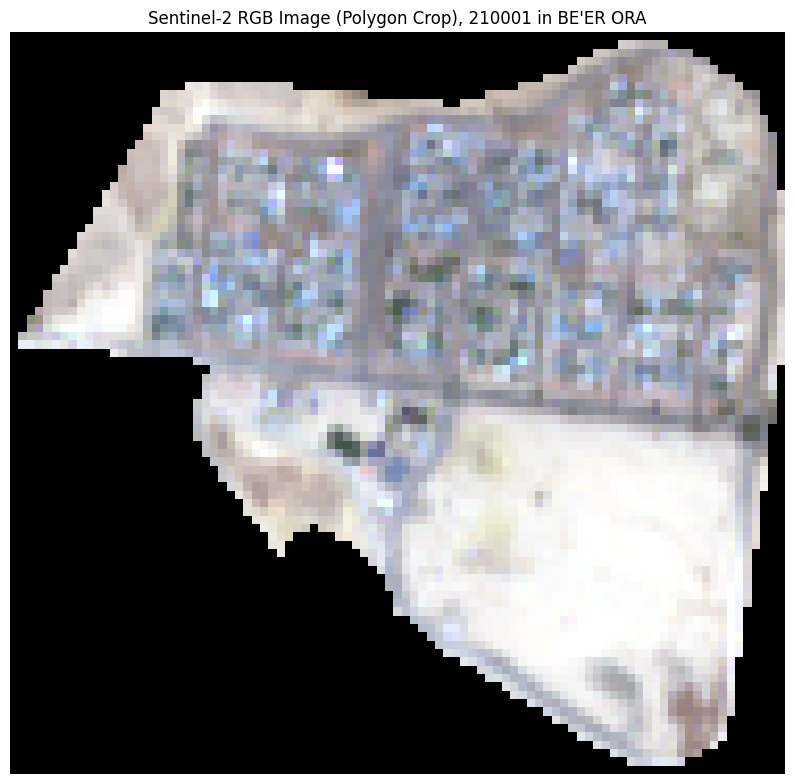

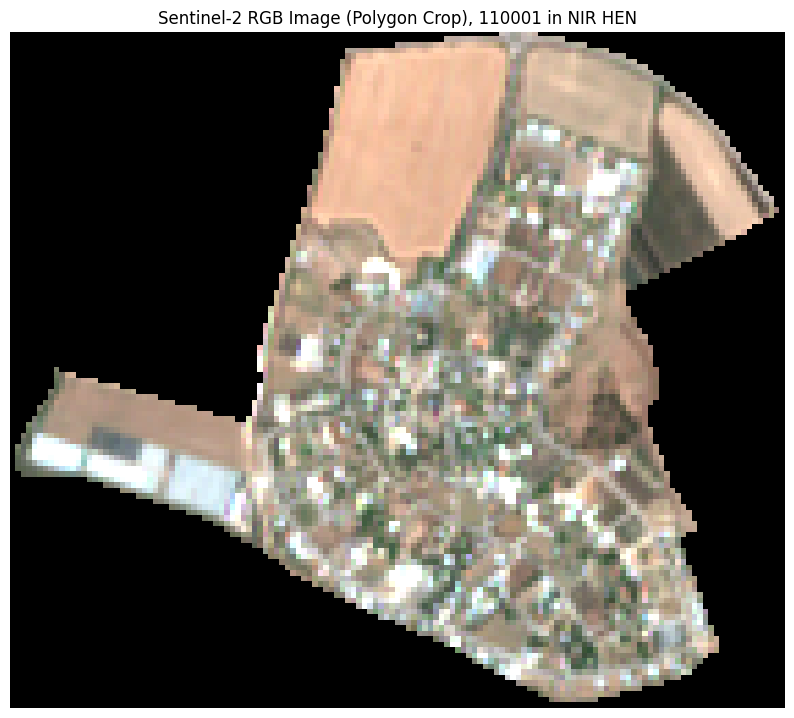

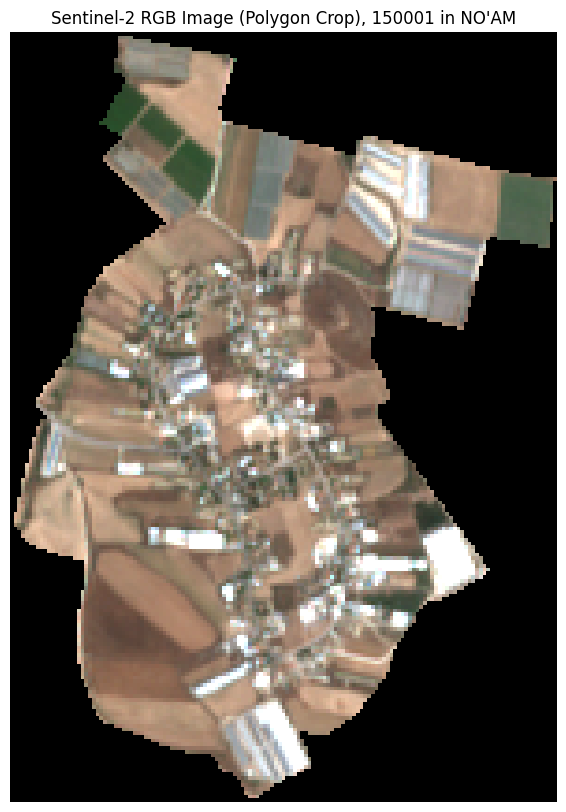

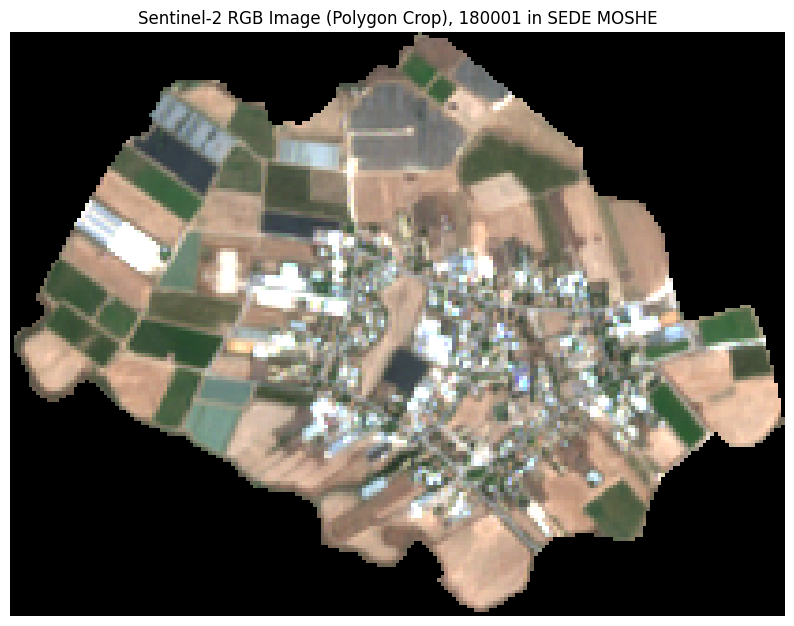

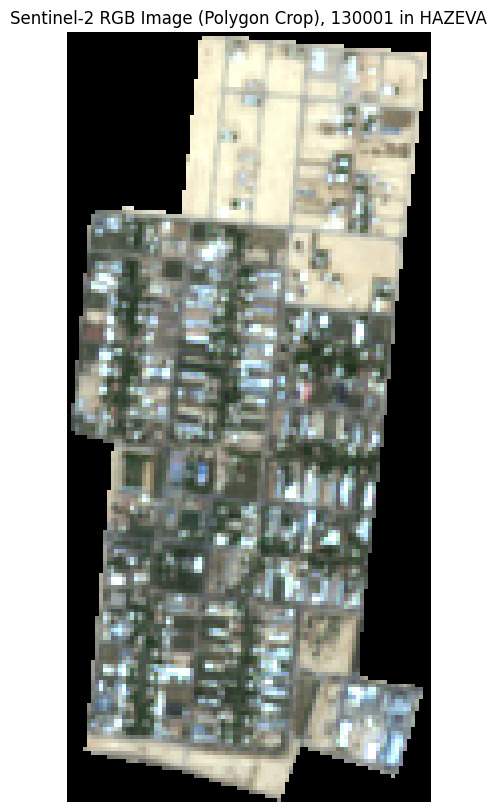

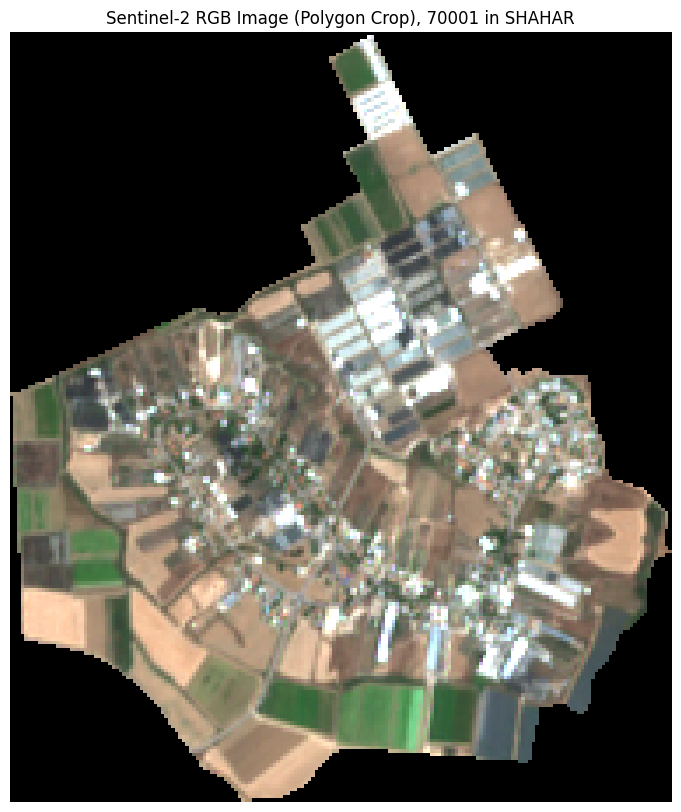

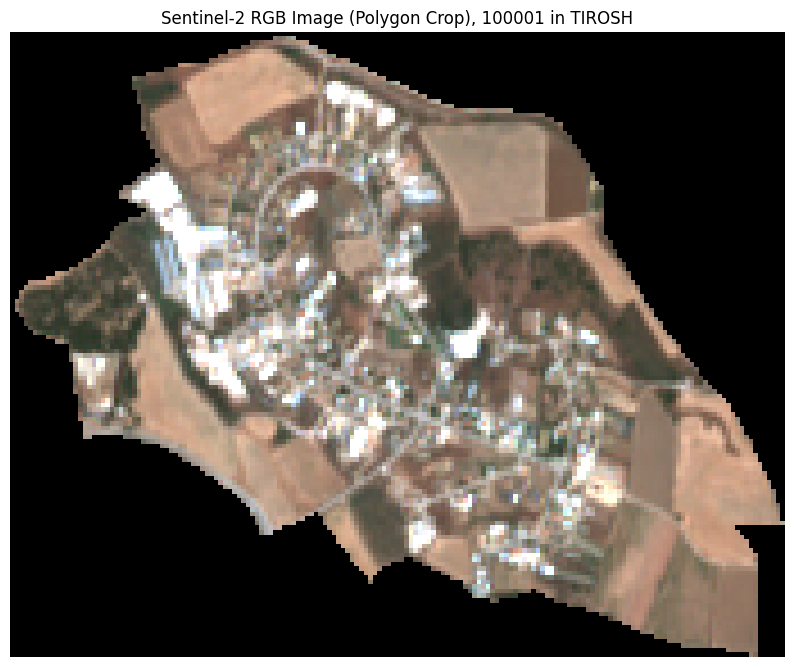

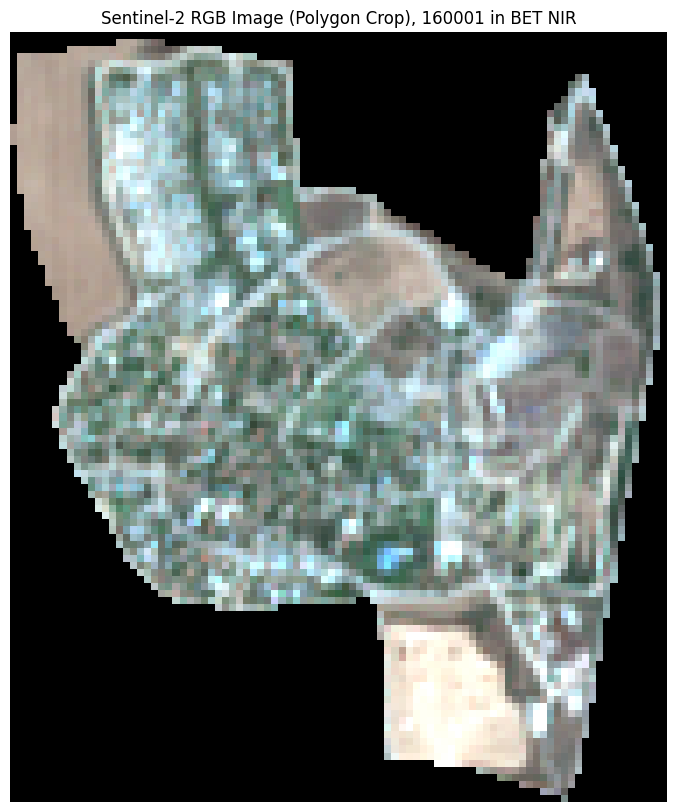

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
def plot_max_coverage_area(gdf_multipolygon, gdf_aerial, band_colors, metadata, flag_output=False, iter_n=8, normalize_band_plim=(2,98)):
    """
    Plot the polygon with the highest coverage for each multipolygon from gdf_multipolygon.
    
    Parameters:
    - gdf_multipolygon: GeoDataFrame with multipolygons and intersection percentages.
    - gdf_aerial: GeoDataFrame with individual polygons.
    - band_colors: Dictionary mapping 'R', 'G', 'B' to Sentinel-2 band codes.
    - metadata: Dictionary with metadata for Sentinel-2 imagery.
    - flag_output: Boolean to control whether to return NumPy arrays or plot images.
    - iter_n: Number of polygons to iterate over.
    - normalize_band_plim: tuple truncate prectile of each pand (as outside 2% 98%)
    
    Returns:
    - If flag_output is True, returns a dictionary with NumPy arrays of the images.
    """

    output = {}
    
    gdf_multipolygon_f = gdf_multipolygon
    if iter_n:
        gdf_multipolygon_f = gdf_multipolygon.head(iter_n)


    for i, best_coverage in enumerate(gdf_aerial['field_key']):
        

        # Find the polygon with the highest intersection percentage for this multipolygon
        gdf_current = gdf_multipolygon_f[ gdf_multipolygon_f['index_max_gdf_aerial'] == i]
        if not gdf_current.empty:
            path_best_coverage = 'data/' + best_coverage
    
            if flag_output:
                # Collect the NumPy arrays instead of plotting
                output[i] = numpy_rgb_correction(
                    path_best_coverage, 
                    band_colors, 
                    metadata[best_coverage], 
                    gdf_current, 
                    polygon_crs=gdf_current.crs, 
                    flag_return=flag_output,
                    normalize_band_plim = normalize_band_plim
                )
            else:
                # Directly plot the RGB image
                rgb_image = numpy_rgb_correction(
                    path_best_coverage, 
                    band_colors, 
                    metadata[best_coverage],
                    gdf_current,
                    polygon_crs=gdf_current.crs, 
                    flag_return=flag_output,
                    normalize_band_plim = normalize_band_plim
                )

                for i, geo_row_city in gdf_current.iterrows():
                    if rgb_image[i] is not None:
                        code = geo_row_city.get('Muni_Eng')
                        if not code:
                            code = str(geo_row_city.get('YISHUV_STA')) + " in " + str(geo_row_city.get('SHEM_YIS_1'))
                        title = f"Sentinel-2 RGB Image (Polygon Crop), {code}"
                        plot_rgb_image(rgb_image[i], title)

    if flag_output:
        return output


# Original channels: 'R' -> 'B04', 'G' -> 'B03', 'B' -> 'B02'
band_colors = {'R': 'B04', 'G': 'B03', 'B': 'B02'}
    
# Example usage of the function
plot_max_coverage_area(spatial_division['statistical_areas']['gdf'], gdf_aerial, band_colors, all_metadata, normalize_band_plim=(2,98))

Note: For safety reasons, in a small number of cases, if the raster does not cover the entire polygon, we choose to omit these cases (always using the maximum coverage, and if the maximum is less than 85%, omit the case). This avoids concerns about merging rasters from different timestamps, which may have other configurations and could introduce complications. (note: we used mostly in statistical_areas so it doesn't that matter).

In [19]:
a = spatial_division['statistical_areas']['gdf']
a[a['intersection_percentage'].apply(lambda x: max(x) < 85) ]

Empty GeoDataFrame
Columns: [OBJECTID, SEMEL_YISH, SHEM_YISHU, SHEM_YIS_1, STAT_2022, YISHUV_STA, ROVA, TAT_ROVA, COD_TIFKUD, SHAPE_Leng, SHAPE_Area, geometry, intersection_percentage, index_max_gdf_aerial]
Index: []

In [20]:
a = gdf_multipolygon
a[a['intersection_percentage'].apply(lambda x: max(x) < 85) ]

CR_PNIM                                           geometry  \
183    5548  POLYGON Z ((34.73832 31.13028 0, 34.73833 31.1...   
188    5554  POLYGON Z ((35.23735 30.81945 0, 35.23774 30.8...   

              Muni_Eng CR_LAMAS       Muni_Heb  \
183        Ramat Negev     None        רמת נגב   
188  Ha'arava Hatihona     None  הערבה התיכונה   

                               intersection_percentage  index_max_gdf_aerial  
183  [0.0, 39.920883229465495, 72.0321233260013, 0....                     2  
188  [0.0, 56.29947392208442, 36.71943276155171, 33...                     1

In [21]:
for key, val in spatial_division.items():
    a = spatial_division[key]['gdf']
    spatial_division[key]['gdf'] = a[a['intersection_percentage'].apply(lambda x: max(x) >= 85) ]


in example, in NIR colors, we didn't omit:

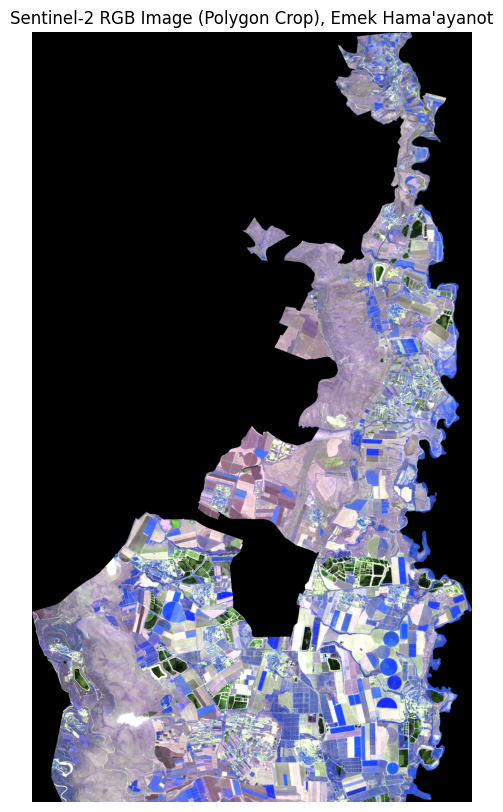

In [22]:
spring_multipolygon = gdf_multipolygon.loc[gdf_multipolygon['Muni_Heb'].str.contains("המעיינות", na=False)]
# Find the polygon with the highest intersection percentage for this multipolygon
band_colors = {'R': 'B04', 'G': 'B03', 'B': 'B08'}
plot_max_coverage_area(spring_multipolygon, gdf_aerial, band_colors, all_metadata)

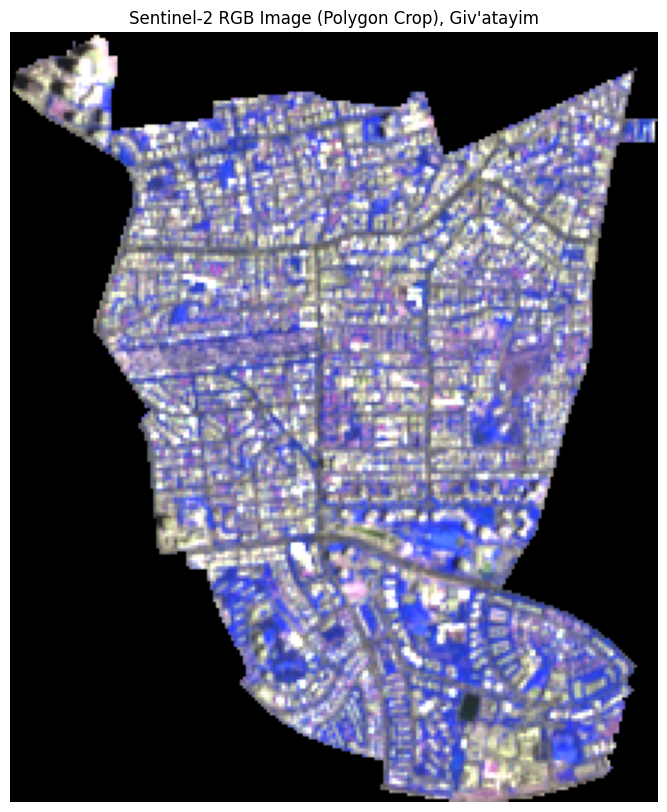

In [23]:
givatayim_multipolygon = gdf_multipolygon.loc[gdf_multipolygon['Muni_Heb'].str.contains("גבעתיים", na=False)]
band_colors = {'R': 'B04', 'G': 'B03', 'B': 'B08'}
plot_max_coverage_area(givatayim_multipolygon, gdf_aerial, band_colors, all_metadata)

now retreive all data

In [48]:
import pickle

save_all = True

if save_all:

    wanted_keys = ['statistical_areas']
    n_rows = None  # Set to None to use the full DataFrame or specify the number of rows you want
    batch_number = 0  # Specify the starting batch number (0 is default, can start from 2 if needed)

    for key in wanted_keys:
        # Determine how many rows to process at a time (100 rows per batch)
        poly = spatial_division[key]['gdf']
        if n_rows is not None:
            poly = poly.head(n_rows)
            
        # Split the data into chunks of 100 rows
        batch_size = 100
        num_batches = len(poly) // batch_size + (1 if len(poly) % batch_size != 0 else 0)

        # Start processing from the specified batch number
        for i in range(batch_number, num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            poly_batch = poly.iloc[start_idx:end_idx]

            # Apply your processing function to the batch
            data_key = plot_max_coverage_area(poly_batch, gdf_aerial, band_colors, all_metadata, flag_output=True, iter_n=None)

            # Flatten the nested dictionary
            data_key_m = {}
            for level_1_key, level_2_dict in data_key.items():
                for level_2_key, level_3_dict in level_2_dict.items():
                    if isinstance(level_3_dict, dict):
                        data_key_m.update(level_3_dict)

            # Save each batch as a separate pickle file
            with open(f'pkl_stat/{key}_batch_{i + 1}.pkl', 'wb') as f:
                pickle.dump(data_key_m, f)

            print(f"pkl_stat/Saved {key}_batch_{i + 1}.pkl")


pkl_stat/Saved statistical_areas_batch_1.pkl
pkl_stat/Saved statistical_areas_batch_2.pkl
pkl_stat/Saved statistical_areas_batch_3.pkl
pkl_stat/Saved statistical_areas_batch_4.pkl
pkl_stat/Saved statistical_areas_batch_5.pkl
pkl_stat/Saved statistical_areas_batch_6.pkl
pkl_stat/Saved statistical_areas_batch_7.pkl
pkl_stat/Saved statistical_areas_batch_8.pkl
pkl_stat/Saved statistical_areas_batch_9.pkl
pkl_stat/Saved statistical_areas_batch_10.pkl
pkl_stat/Saved statistical_areas_batch_11.pkl
pkl_stat/Saved statistical_areas_batch_12.pkl
pkl_stat/Saved statistical_areas_batch_13.pkl
pkl_stat/Saved statistical_areas_batch_14.pkl
pkl_stat/Saved statistical_areas_batch_15.pkl
pkl_stat/Saved statistical_areas_batch_16.pkl
pkl_stat/Saved statistical_areas_batch_17.pkl
pkl_stat/Saved statistical_areas_batch_18.pkl
pkl_stat/Saved statistical_areas_batch_19.pkl
pkl_stat/Saved statistical_areas_batch_20.pkl
pkl_stat/Saved statistical_areas_batch_21.pkl
pkl_stat/Saved statistical_areas_batch_22.p